# 0. Solution Planning

## 0.1. Input

1. Business Problem
    - Select most valuable clientsto be part of a loyalty program

2. Dataset
    - Sales from an e-commerce during one year

## 0.2. Output

1. People indication to be part of the loyalty program
    - List of clients tagged

2. Report with the business questions

    - Who are the elegible people to participate in the loyalty program?
    - How many clients will be part of the loyalty program?
    - Which are the main client characteristics?
    - What is the percentage of profit contribution that comes from the loyalty program?
    - What is the profit expectation from this group in the next months?
    - What are the conditions that makes someone elegible to the loyalty program?
    - What are the conditions that makes someone not elegible anymore to the loyalty program?
    - What are the metrics to decide if the loyalty program people are really better than the rest of the database?
    - What could the marketing team do to improve the profit?

## 0.3. Tasks

Who are the elegible people to participate in the loyalty program?
- High average ticket;
- High LTV (Life Time Value);
- High purchase frequency;
- High basket size;
- Low churn probability;
- High purchase propensity.
- Low number of devolutions;
- Experience;
- High number of ratings.

How many clients will be part of the loyalty program?
- Percentage of total clients.

What are the main client characteristics?
- Important client attributes (age, country, salary);
- Client purchasing behavior.

What is the percentage of profit contribution that comes from the loyalty program?
- Get the total profit of the company during the year and the percentage of the cluster.

What are the conditions that make someone elegible to the loyalty program?
- The average performance of the client is close to the average performance of the clients from the loyalty program.

# 1. Imports

In [1]:
import sqlite3
import numpy as np
import regex as re
import pandas as pd
import seaborn as sns
import umap.umap_ as umap

from sklearn import metrics
from quickda import explore_data
from datetime import datetime
from matplotlib import cm
from sqlalchemy import create_engine
from IPython.display import HTML, Image
from sklearn.neighbors import NearestNeighbors

from plotly import express as px
from sklearn import cluster as c
from sklearn import mixture as mx
from sklearn import ensemble as en
from sklearn import manifold as mn
from sklearn import preprocessing as pp
from sklearn import decomposition as dd
from matplotlib import pyplot as plt
from scipy.cluster import hierarchy as hc

## 1.1. Helper Functions

In [2]:
def settings():

    %matplotlib inline
    plt.style.use('ggplot')
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.rcParams['font.size'] = 24

    display(HTML('<style>.container { width:100% !important; }</style>'))

    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.float_format', lambda x: '%.4f' % x)
    pd.set_option('display.expand_frame_repr', False)

    sns.set()

settings()

## 1.2. Load Dataset

In [3]:
df_raw = pd.read_csv('../data/Ecommerce.csv', encoding='unicode_escape')

df_raw.drop(columns=['Unnamed: 8'], inplace=True)

In [4]:
df_raw.head()

InvoiceNo StockCode                          Description  Quantity InvoiceDate  UnitPrice  CustomerID         Country
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   29-Nov-16     2.5500  17850.0000  United Kingdom
1    536365     71053                  WHITE METAL LANTERN         6   29-Nov-16     3.3900  17850.0000  United Kingdom
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   29-Nov-16     2.7500  17850.0000  United Kingdom
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   29-Nov-16     3.3900  17850.0000  United Kingdom
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   29-Nov-16     3.3900  17850.0000  United Kingdom

# 2. Data Description

In [5]:
df1 = df_raw.copy()

## 2.1. Rename Columns

In [6]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']

df1.columns = cols_new

## 2.2. Data Dimension

In [7]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 541909
Number of Cols: 8


## 2.3. Check NA

In [8]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 2.4. Replace NA

In [9]:
df_missing = df1.loc[df1['customer_id'].isna(), :]
df_not_missing = df1.loc[~df1['customer_id'].isna(), :]

In [10]:
# create reference
df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange(19000, 19000+len(df_backup), 1)

# merge original with reference dataframe
df1 = pd.merge(df1, df_backup, on='invoice_no', how='left')

# coalesce 
df1['customer_id'] = df1['customer_id_x'].combine_first( df1['customer_id_y'])

# drop extra columns
df1 = df1.drop(columns=['customer_id_x', 'customer_id_y'], axis=1)

In [11]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

## 2.6. Check Data Types

In [12]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
country          object
customer_id     float64
dtype: object

## 2.4. Change Data Types

In [13]:
# invoice_date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

# customer_id
df1['customer_id'] = df1['customer_id'].astype(int)

In [14]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

## 2.7. Descriptive Statistics

In [15]:
num_attributes = df1.select_dtypes(include=['int64', 'int32', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 2.7.1. Numerical Attributes

In [16]:
num_attributes.head()

quantity  unit_price  customer_id
0         6      2.5500        17850
1         6      3.3900        17850
2         8      2.7500        17850
3         6      3.3900        17850
4         6      3.3900        17850

In [17]:
# Central Tendency: mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion: std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

attributes         min        max       range       mean     median       std     skew    kurtosis
0     quantity -80995.0000 80995.0000 161990.0000     9.5522     3.0000  218.0810  -0.2641 119769.1600
1   unit_price -11062.0600 38970.0000  50032.0600     4.6111     2.0800   96.7598 186.5070  59005.7191
2  customer_id  12346.0000 22709.0000  10363.0000 16688.8405 16249.0000 2911.4087   0.4874     -0.8043

1. Quantity with negative value;

2. Unit price equal to zero.

### 2.7.2. Categorical Attributes

In [18]:
cat_attributes.head()

invoice_no stock_code                          description         country
0     536365     85123A   WHITE HANGING HEART T-LIGHT HOLDER  United Kingdom
1     536365      71053                  WHITE METAL LANTERN  United Kingdom
2     536365     84406B       CREAM CUPID HEARTS COAT HANGER  United Kingdom
3     536365     84029G  KNITTED UNION FLAG HOT WATER BOTTLE  United Kingdom
4     536365     84029E       RED WOOLLY HOTTIE WHITE HEART.  United Kingdom

In [19]:
# invoice_no
df_letter_invoices = df1.loc[df1['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x))), :]

print('Total number of invoices with letters: {}'.format(len(df_letter_invoices)))

print('Total number of negative quantities with letter in the invoice: {}'.format(len(df_letter_invoices[df_letter_invoices['quantity']< 0])))

Total number of invoices with letters: 9291
Total number of negative quantities with letter in the invoice: 9288


In [20]:
# stock_code
print('Number of stock codes with at least one letter: {}'.format(len(cat_attributes.loc[cat_attributes['stock_code'].apply(lambda x: bool(re.search('[^0-9]+', x))), 'stock_code'].drop_duplicates())))

print('List of stock codes composed only by letters: {}'.format(df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), 'stock_code'].unique()))


Number of stock codes with at least one letter: 1124
List of stock codes composed only by letters: ['POST' 'D' 'DOT' 'M' 'S' 'AMAZONFEE' 'm' 'DCGSSBOY' 'DCGSSGIRL' 'PADS'
 'B' 'CRUK']


In [21]:
# country
print('Number of countries in the database: {}'.format(len(df1['country'].unique())))
print('\nSome of these countries: \n{}'.format(df1['country'].value_counts(normalize=True).head(10)))

Number of countries in the database: 38

Some of these countries: 
United Kingdom   0.9143
Germany          0.0175
France           0.0158
EIRE             0.0151
Spain            0.0047
Netherlands      0.0044
Belgium          0.0038
Switzerland      0.0037
Portugal         0.0028
Australia        0.0023
Name: country, dtype: float64


# 3. Variable Filtering

In [22]:
df2 = df1.copy()

In [23]:
# unit price
df2 = df2.loc[df2['unit_price'] > 0.04, :]

# stock_code
df2 = df2[~df2['stock_code'].isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK'])]

# description
df2 = df2.drop(columns='description', axis=1)

# map
df2 = df2[~df2['country'].isin(['European Community', 'Unspecified'])]

# bad users
df2 = df2[~df2['customer_id'].isin( [16446] )]

# quantity
df2_returns = df2.loc[df2['quantity'] < 0, :]
df2_purchases = df2.loc[df2['quantity'] >= 0, :]

# 4. Feature Engineering

In [24]:
df3 = df2.copy()

## 4.1. Feature Creation

In [25]:
# data reference
df_ref = df3.drop(['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price', 'country'], axis=1)
df_ref = df_ref.drop_duplicates(ignore_index=True)

### 4.1.1. Gross Revenue

In [26]:
# gross revenue (profit) quantity * price
df2_purchases.loc[:, 'gross_revenue'] = df2_purchases.loc[:, 'quantity'] * df2_purchases.loc[:, 'unit_price']

# monetary
df_monetary = df2_purchases[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')

/tmp/ipykernel_234264/1551767982.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### 4.1.2. Recency

In [27]:
df_recency = df2_purchases.loc[:, ['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency.loc[:, ['customer_id', 'recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')

### 4.1.3. Quantity of Purchases

In [28]:
df_freq = df2_purchases.loc[:, ['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index().rename(columns={'invoice_no': 'q_invoices'})
df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')

### 4.1.4. Quantity of Items Purchased

In [29]:
df_freq = df2_purchases.loc[:, ['customer_id', 'quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity': 'q_items'})
df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')

### 4.1.5. Quantity of Products Purchased

In [30]:
df_freq = df2_purchases.loc[:, ['customer_id', 'stock_code']].groupby('customer_id').count().reset_index().rename(columns={'stock_code': 'q_products'})
df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')

### 4.1.6. Average Ticket Value

In [31]:
df_avg_ticket = df2_purchases.loc[:, ['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue':'avg_ticket'})
df_ref = pd.merge(df_ref, df_avg_ticket, on='customer_id', how='left')

### 4.1.7. Average Recency Days

In [32]:
df_aux = df2[['customer_id', 'invoice_date']].drop_duplicates().sort_values( ['customer_id', 'invoice_date'], ascending=[False, False])
df_aux['next_customer_id'] = df_aux['customer_id'].shift() # next customer
df_aux['previous_date'] = df_aux['invoice_date'].shift() # next invoince date

df_aux['avg_recency_days'] = df_aux.apply(lambda x: (x['previous_date'] - x['invoice_date']).days if x['customer_id'] == x['next_customer_id'] else np.nan, axis=1)

df_aux = df_aux.drop(['invoice_date', 'next_customer_id', 'previous_date'], axis=1).dropna()

df_avg_recency_days = df_aux.groupby('customer_id').mean().reset_index()

df_ref = pd.merge(df_ref, df_avg_recency_days, on='customer_id', how='left')

### 4.1.8. Frequency

In [33]:
df_aux = (df2_purchases[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                            .groupby('customer_id')
                                                            .agg(max_ = ( 'invoice_date', 'max'), 
                                                                 min_ = ( 'invoice_date', 'min'),
                                                                 days_= ( 'invoice_date', lambda x: ((x.max() - x.min()).days) + 1),
                                                                 buy_ = ( 'invoice_no', 'count'))).reset_index()

df_aux['frequency'] = df_aux[['buy_', 'days_']].apply(lambda x: x['buy_'] / x['days_'] if  x['days_'] != 0 else 0, axis=1)
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'frequency']], on='customer_id', how='left')

### 4.1.9. Returns

In [34]:
df_returns = df2_returns[['customer_id', 'quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity':'q_returns'})
df_returns['q_returns'] = df_returns['q_returns'] * -1

df_ref = pd.merge(df_ref, df_returns, how='left', on='customer_id')
df_ref.loc[df_ref['q_returns'].isna(), 'q_returns'] = 0


### 4.1.10. Basket Size

In [35]:
df_aux = (df2_purchases.loc[:, ['customer_id', 'invoice_no', 'quantity']].groupby('customer_id').agg(n_purchases=('invoice_no', 'nunique'),
                                                                                                     n_products=('quantity', 'sum')).reset_index())

df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchases']

df_ref = pd.merge(df_ref, df_aux[['customer_id', 'avg_basket_size']], how='left', on='customer_id')

### 4.1.11. Unique Basket Size

In [36]:
df_aux = (df2_purchases.loc[:, ['customer_id', 'invoice_no', 'stock_code']].groupby('customer_id').agg(n_purchases=('invoice_no', 'nunique'),
                                                                                                       n_products=('stock_code', 'nunique')).reset_index())

df_aux['avg_unique_basket_size'] = df_aux['n_products'] / df_aux['n_purchases']

df_ref = pd.merge(df_ref, df_aux[['customer_id', 'avg_unique_basket_size']], how='left', on='customer_id')

## 4.2. Check Dataframe

In [37]:
# check na
df_ref.isna().sum()

customer_id                  0
gross_revenue               91
recency_days                91
q_invoices                  91
q_items                     91
q_products                  91
avg_ticket                  91
avg_recency_days          2816
frequency                   91
q_returns                    0
avg_basket_size             91
avg_unique_basket_size      91
dtype: int64

In [38]:
df_ref.head()

customer_id  gross_revenue  recency_days  q_invoices   q_items  q_products  avg_ticket  avg_recency_days  frequency  q_returns  avg_basket_size  avg_unique_basket_size
0        17850      5391.2100      372.0000     34.0000 1733.0000    297.0000     18.1522           35.5000    17.0000    40.0000          50.9706                  0.6176
1        13047      3232.5900       56.0000      9.0000 1390.0000    171.0000     18.9040           27.2500     0.0283    35.0000         154.4444                 11.6667
2        12583      6705.3800        2.0000     15.0000 5028.0000    232.0000     28.9025           23.1875     0.0403    50.0000         335.2000                  7.6000
3        13748       948.2500       95.0000      5.0000  439.0000     28.0000     33.8661           92.6667     0.0179     0.0000          87.8000                  4.8000
4        15100       876.0000      333.0000      3.0000   80.0000      3.0000    292.0000            8.6000     0.0732    22.0000          26.6667                  0.3333

# 5. EDA (Exploratory Data Analysis)

In [39]:
cols_selected = ['customer_id', 'gross_revenue', 'recency_days', 'q_products', 'frequency', 'q_returns']
df_selected = df_ref[cols_selected].copy()

df4 = df_selected.dropna().copy()
df4.isna().sum()

customer_id      0
gross_revenue    0
recency_days     0
q_products       0
frequency        0
q_returns        0
dtype: int64

## 5.1. Univariate Analysis

In [40]:
#explore_data.explore(df4, method='profile', report_name='clients')

## 5.2. Bivariate Analysis

In [41]:
#cols = ['customer_id']
#df4_2 = df4.drop(cols, axis=1)
#plt.figure(figsize=(25, 12));
#sns.pairplot(df4_2);

## 5.3. Space Study

In [42]:
# selected dataset
df4_3 = df4[cols_selected].drop(columns='customer_id', axis=1)

In [43]:
mm = pp.MinMaxScaler()

df4_3['gross_revenue'] = mm.fit_transform(df4_3[['gross_revenue']]) 
df4_3['recency_days'] = mm.fit_transform(df4_3[['recency_days']]) 
df4_3['q_products'] = mm.fit_transform(df4_3[['q_products']]) 
df4_3['frequency'] = mm.fit_transform(df4_3[['frequency']]) 
df4_3['q_returns'] = mm.fit_transform(df4_3[['q_returns']]) 

X = df4_3.copy()

### 5.3.1. PCA

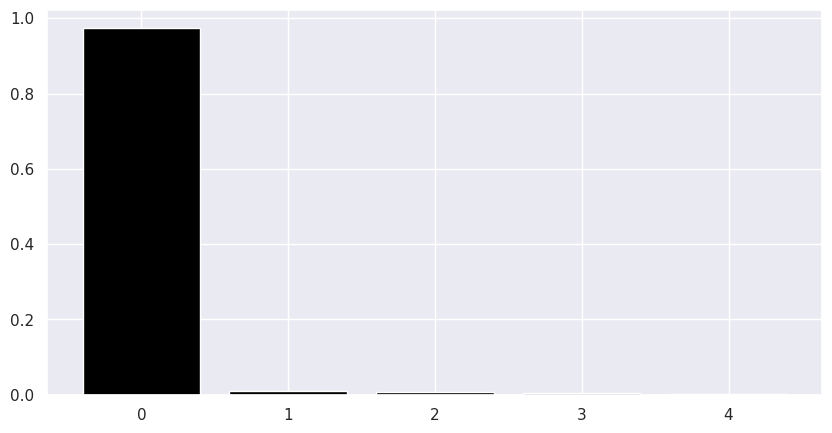

In [44]:
pca = dd.PCA(n_components=X.shape[1])

principal_components = pca.fit_transform(X)

# plot explained variable
features = range(pca.n_components_)

plt.bar(features, pca.explained_variance_ratio_, color='black')

# pca component
df_pca = pd.DataFrame(principal_components)

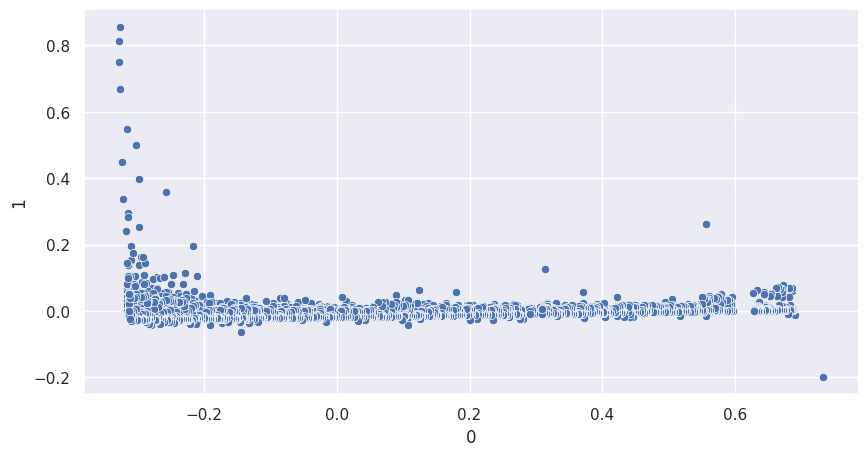

In [45]:
sns.scatterplot(x=0, y=1, data=df_pca);

### 5.3.2. UMAP

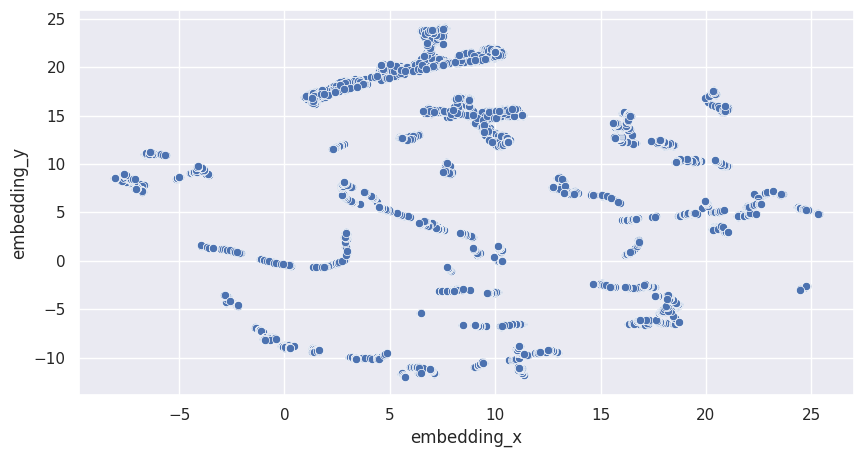

In [46]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X)

# embedding
df_umap = pd.DataFrame()
df_umap['embedding_x'] = embedding[:, 0]
df_umap['embedding_y'] = embedding[:, 1]

sns.scatterplot(x='embedding_x', y='embedding_y', data=df_umap);

### 5.3.3. t-SNE

/home/matheusandrade/anaconda3/envs/loyalty-program/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/home/matheusandrade/anaconda3/envs/loyalty-program/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



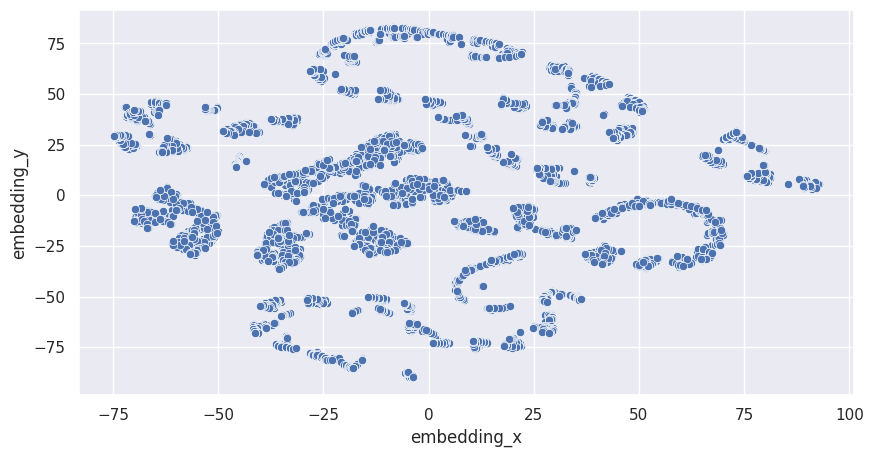

In [47]:
reducer = mn.TSNE(n_components=2, n_jobs=-1, random_state=42)
embedding = reducer.fit_transform(X)

# embedding
df_tsne = pd.DataFrame()
df_tsne['embedding_x'] = embedding[:, 0]
df_tsne['embedding_y'] = embedding[:, 1]

sns.scatterplot(x='embedding_x', y='embedding_y', data=df_tsne);

### 5.3.4. Tree-Based Embedding

In [48]:
# training dataset
X = df4_3.drop(columns=['gross_revenue'], axis=1)
y = df4_3['gross_revenue']

# model definition
rf_model = en.RandomForestRegressor(n_estimators=1000, random_state=42)

# model training
rf_model.fit(X, y)

# dataframe leaf
df_leaf = pd.DataFrame(rf_model.apply(X))

/home/matheusandrade/anaconda3/envs/loyalty-program/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



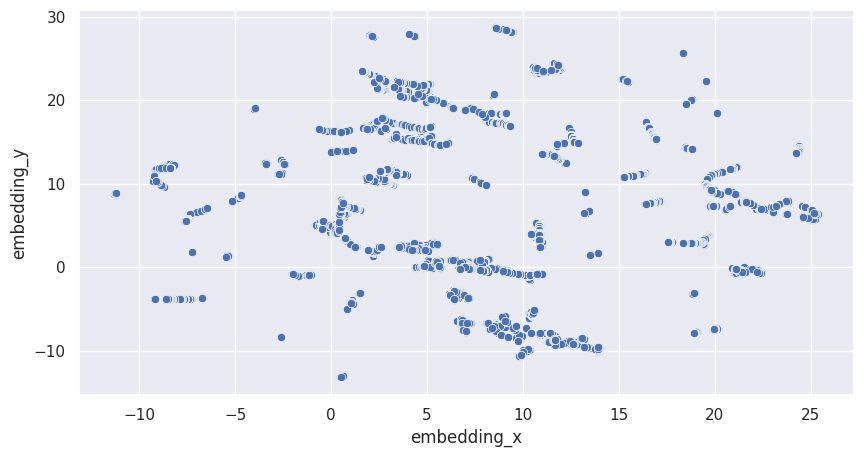

In [49]:
# dimensionality reduction
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df_leaf)

# embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

sns.scatterplot(x='embedding_x', y='embedding_y', data=df_tree);

# 6. Data Preparation

In [50]:
df5 = df4_3.copy()
df5_aux = df4_3.copy()

# umap embedding
df5_umap = df_umap.copy()
df5_umap.to_csv('../data/umap_embedding.csv', index=False)

# tsne embedding
df5_tsne = df_tsne.copy()

# tree embedding
df5_tree = df_tree.copy()

- Normal DIstribution with no Outliers -> Standard Scaler - Mean and Standard Deviation
- Normal DIstribution with Outliers -> Robust Scaler - Quartiles
- Not Normal Distribution -> Min Max Scaler

In [51]:
mm_gross_revenue = pp.MinMaxScaler()
mm_recency_days = pp.MinMaxScaler()
mm_q_products = pp.MinMaxScaler()
mm_frequency = pp.MinMaxScaler()
mm_q_returns = pp.MinMaxScaler()

df5['gross_revenue'] = mm_gross_revenue.fit_transform( df5[['gross_revenue']] )
df5['recency_days'] = mm_recency_days.fit_transform( df5[['recency_days']] )
#df5['q_invoices'] = mm.fit_transform( df5[['q_invoices']] )
#df5['q_items'] = mm.fit_transform( df5[['q_items']] )
df5['q_products'] = mm_q_products.fit_transform( df5[['q_products']] )
#df5['avg_ticket'] = mm.fit_transform( df5[['avg_ticket']] )
#df5['avg_recency_days'] = mm.fit_transform( df5[['avg_recency_days']] )
df5['frequency'] = mm_frequency.fit_transform( df5[['frequency']] )
df5['q_returns'] = mm_q_returns.fit_transform( df5[['q_returns']] )
#df5['avg_basket_size'] = mm.fit_transform( df5[['avg_basket_size']] )
#df5['avg_unique_basket_size'] = mm.fit_transform( df5[['avg_unique_basket_size']] )

# 7. Feature Selection

In [52]:
df6 = df5.copy()

df6_umap = df5_umap.copy()

df6_tsne = df5_tsne.copy()

df6_tree = df5_tree.copy()

# 8. Hyperparameter Fine Tuning

In [53]:
X = df6.copy()

X_umap = df6_umap.copy()

X_tsne = df6_tsne.copy()

X_tree = df6_tree.copy()

In [54]:
X.head()

gross_revenue  recency_days  q_products  frequency  q_returns
0         0.0193        0.9973      0.0378     1.0000     0.0005
1         0.0116        0.1501      0.0217     0.0013     0.0005
2         0.0240        0.0054      0.0295     0.0021     0.0007
3         0.0034        0.2547      0.0034     0.0007     0.0000
4         0.0031        0.8928      0.0003     0.0040     0.0003

In [55]:
X_umap.head()

embedding_x  embedding_y
0      -7.1532       8.1363
1       7.6697      10.0700
2       3.4839      18.7296
3      13.6444       6.9062
4      -3.9575       1.5827

In [56]:
X_tsne.head()

embedding_x  embedding_y
0      85.3741       5.4822
1      21.7473     -13.5545
2     -22.4069      11.4263
3      67.0259     -29.3113
4      19.1507     -54.8664

In [57]:
X_tree.head()

embedding_x  embedding_y
0       9.9231      -8.2271
1       6.9502      -6.5949
2       8.7015      -7.8303
3      21.5367      -0.2061
4      20.8157       9.0180

In [58]:
clusters = [2, 3, 4, 5, 6, 7]
clusters_umap = np.arange(2, 16, 1)
clusters_tsne = np.arange(2, 16, 1)
clusters_tree = np.arange(2, 16, 1)

## 8.1. K-Means

### 8.1.1. Feature Space

In [59]:
kmeans_list = []
for k in clusters:
    print('Iteration: {}'.format(k))
    # model definition
    kmeans_model = c.KMeans(init='random', n_clusters=k, n_init=500, max_iter=300, random_state=42)

    # model training
    kmeans_model.fit(X)

    # model predict
    labels = kmeans_model.predict(X)

    # model performance
    sil = metrics.silhouette_score(X, labels, metric='euclidean')
    kmeans_list.append(sil)

Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7


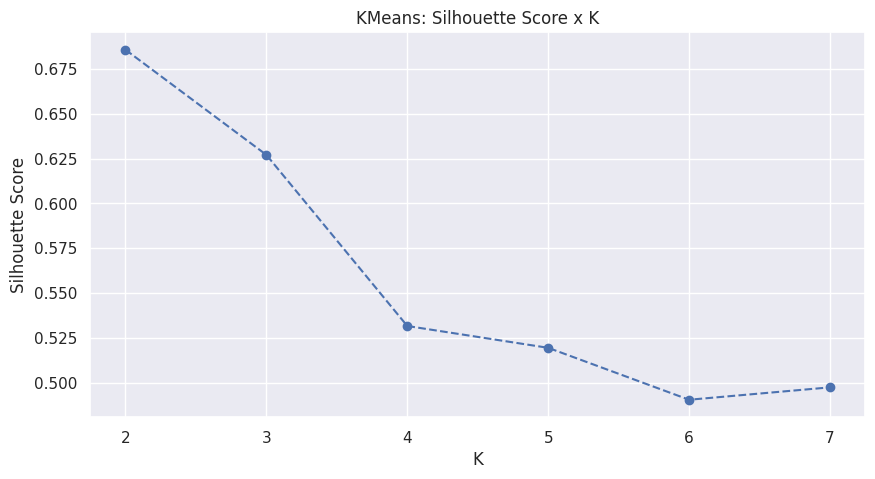

In [60]:
plt.plot(clusters, kmeans_list, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.title('KMeans: Silhouette Score x K');

### 8.1.2. UMAP Embedding Space

In [61]:
kmeans_list_umap = []
for k in clusters_umap:
    
    print('Iteration: {}'.format(k))
    
    # model definition
    kmeans_model_umap = c.KMeans(init='random', n_clusters=k, n_init=500, max_iter=300, random_state=42)

    # model training
    kmeans_model_umap.fit(X_umap)

    # model predict
    labels_umap = kmeans_model_umap.predict(X_umap)

    # model performance
    sil_umap = metrics.silhouette_score(X_umap, labels_umap, metric='euclidean')
    kmeans_list_umap.append(sil_umap)

Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15


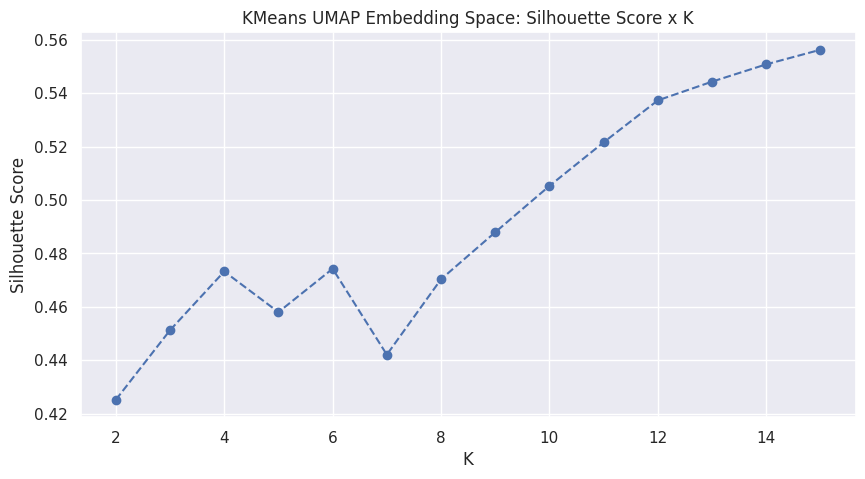

In [62]:
plt.plot(clusters_umap, kmeans_list_umap, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.title('KMeans UMAP Embedding Space: Silhouette Score x K');

### 8.1.3. t-SNE Embedding Space

In [63]:
kmeans_list_tsne = []
for k in clusters_tsne:
    
    print('Iteration: {}'.format(k))
    
    # model definition
    kmeans_model_tsne = c.KMeans(init='random', n_clusters=k, n_init=500, max_iter=300, random_state=42)

    # model training
    kmeans_model_tsne.fit(X_tsne)

    # model predict
    labels_tsne = kmeans_model_tsne.predict(X_tsne)

    # model performance
    sil_tsne = metrics.silhouette_score(X_tsne, labels_tsne, metric='euclidean')
    kmeans_list_tsne.append(sil_tsne)

Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15


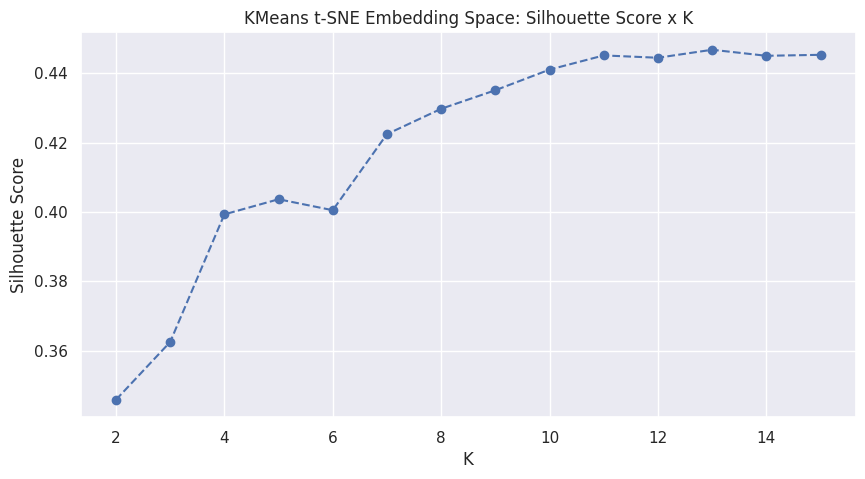

In [64]:
plt.plot(clusters_tsne, kmeans_list_tsne, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.title('KMeans t-SNE Embedding Space: Silhouette Score x K');

### 8.1.4. Tree Embedding Space

In [65]:
kmeans_list_tree = []
for k in clusters_tree:
    
    print('Iteration: {}'.format(k))
    
    # model definition
    kmeans_model_tree = c.KMeans(init='random', n_clusters=k, n_init=500, max_iter=300, random_state=42)

    # model training
    kmeans_model_tree.fit(X_tree)

    # model predict
    labels_tree = kmeans_model_tree.predict(X_tree)

    # model performance
    sil_tree = metrics.silhouette_score(X_tree, labels_tree, metric='euclidean')
    kmeans_list_tree.append(sil_tree)

Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15


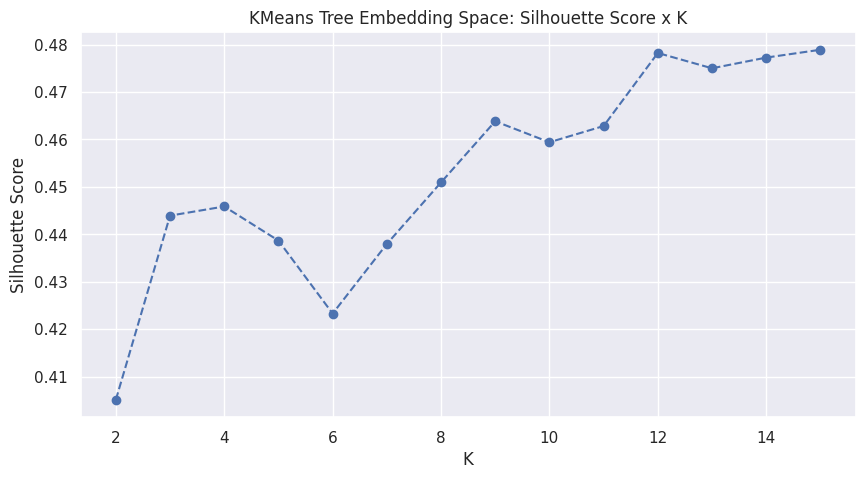

In [66]:
plt.plot(clusters_tree, kmeans_list_tree, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.title('KMeans Tree Embedding Space: Silhouette Score x K');

## 8.2. GMM

### 8.2.1. Features Space

In [67]:
gmm_list = []
for k in clusters:
    
    print('Iteration: {}'.format(k))
    
    # model definition
    gmm_model = mx.GaussianMixture(n_components=k, n_init=100, max_iter=100, random_state=42)

    # model training
    gmm_model.fit(X)

    # model predict
    labels = gmm_model.predict(X)

    # model performance
    sil = metrics.silhouette_score(X, labels, metric='euclidean')
    gmm_list.append(sil)

Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7


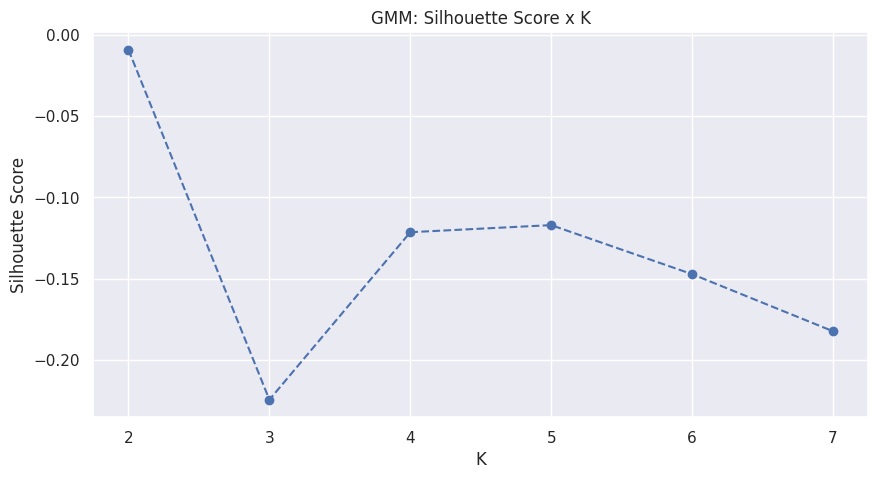

In [68]:
plt.plot(clusters, gmm_list, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.title('GMM: Silhouette Score x K');

### 8.2.2. UMAP Embedding Space

In [69]:
gmm_list_umap = []
for k in clusters_umap:
    
    print('Iteration: {}'.format(k))

    # model definition
    gmm_model_umap = mx.GaussianMixture(n_components=k, n_init=100, max_iter=100, random_state=42)

    # model training
    gmm_model_umap.fit(X_umap)

    # model predict
    labels_umap = gmm_model_umap.predict(X_umap)

    # model performance
    sil_umap = metrics.silhouette_score(X_umap, labels_umap, metric='euclidean')
    gmm_list_umap.append(sil_umap)

Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15


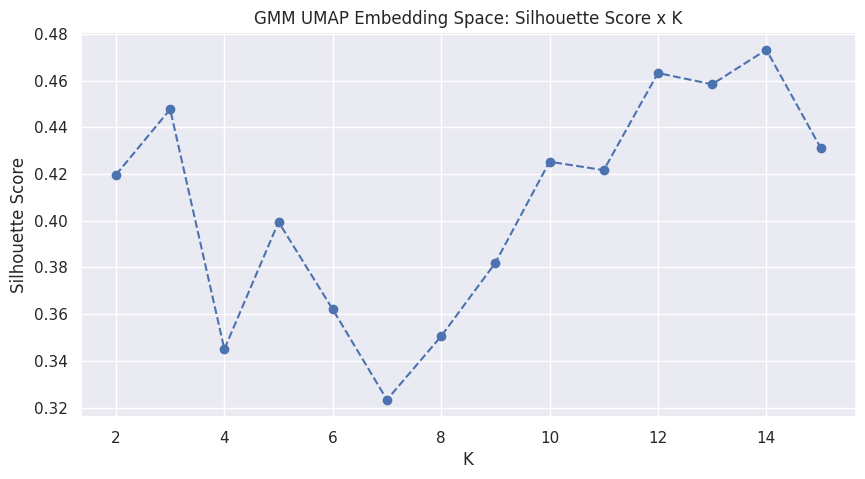

In [70]:
plt.plot(clusters_umap, gmm_list_umap, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.title('GMM UMAP Embedding Space: Silhouette Score x K');

### 8.2.3. t-SNE Embedding Space

In [71]:
gmm_list_tsne = []
for k in clusters_tsne:
    
    print('Iteration: {}'.format(k))

    # model definition
    gmm_model_tsne = mx.GaussianMixture(n_components=k, n_init=100, max_iter=100, random_state=42)

    # model training
    gmm_model_tsne.fit(X_tsne)

    # model predict
    labels_tsne = gmm_model_tsne.predict(X_tsne)

    # model performance
    sil_tsne = metrics.silhouette_score(X_tsne, labels_tsne, metric='euclidean')
    gmm_list_tsne.append(sil_tsne)

Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15


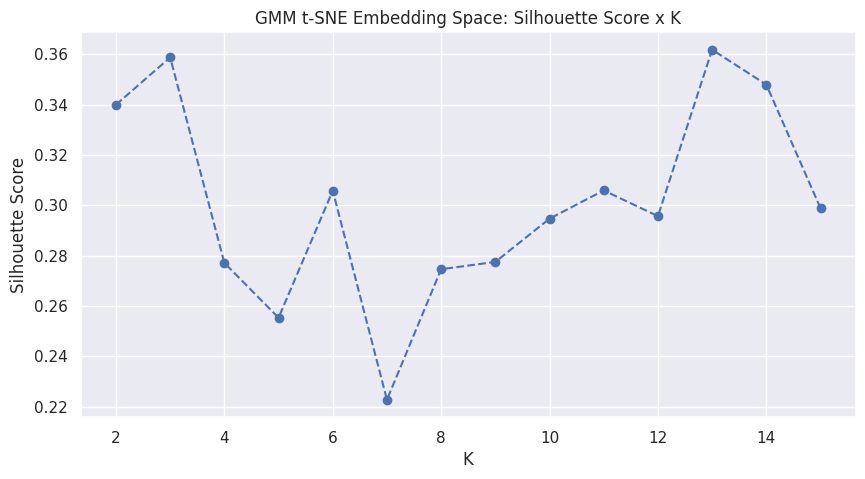

In [72]:
plt.plot(clusters_tsne, gmm_list_tsne, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.title('GMM t-SNE Embedding Space: Silhouette Score x K');

### 8.2.4. Tree Embedding Space

In [73]:
gmm_list_tree = []
for k in clusters_tree:
    
    print('Iteration: {}'.format(k))

    # model definition
    gmm_model_tree = mx.GaussianMixture(n_components=k, n_init=100, max_iter=100, random_state=42)

    # model training
    gmm_model_tree.fit(X_tree)

    # model predict
    labels_tree = gmm_model_tree.predict(X_tree)

    # model performance
    sil_tree = metrics.silhouette_score(X_tree, labels_tree, metric='euclidean')
    gmm_list_tree.append(sil_tree)

Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15


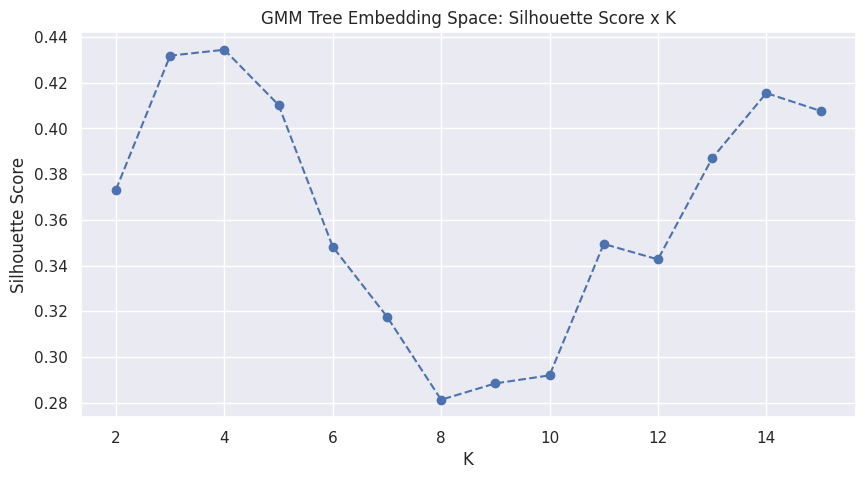

In [74]:
plt.plot(clusters_tree, gmm_list_tree, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.title('GMM Tree Embedding Space: Silhouette Score x K');

## 8.3. Hierarchical Clustering

### 8.3.1. Features Space

In [75]:
# model definition and training
hc_model = hc.linkage(X, 'ward')

[]

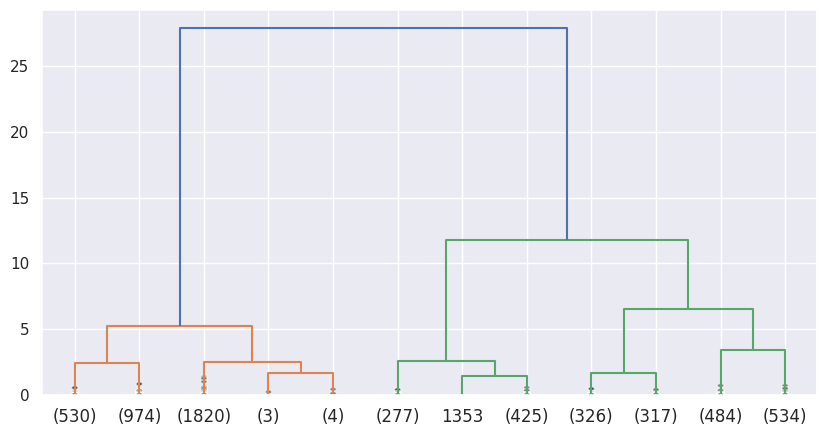

In [76]:
hc.dendrogram(hc_model, truncate_mode='lastp', p=12, show_contracted=True)
plt.plot()

In [77]:
hc_list = []
for k in clusters:
    
    print('Iteration: {}'.format(k))

    # model definition and training
    hc_model = hc.linkage(X, 'ward')

    # model predict
    labels = hc.fcluster(hc_model, k, criterion='maxclust')

    # metrics
    sil = metrics.silhouette_score(X, labels, metric='euclidean')
    hc_list.append(sil)
    

Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7


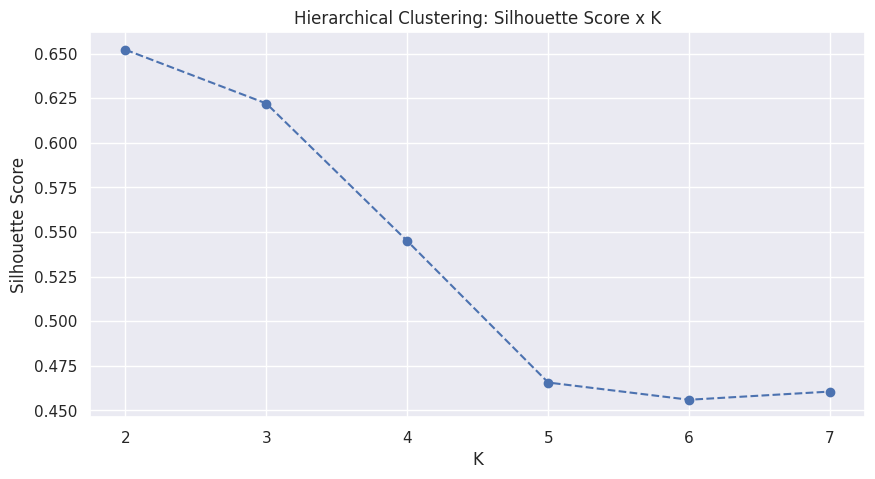

In [78]:
plt.plot(clusters, hc_list, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.title('Hierarchical Clustering: Silhouette Score x K');

### 8.3.2. UMAP Embedding Space

In [79]:
# model definition and training
hc_model_umap = hc.linkage(X_umap, 'ward')

[]

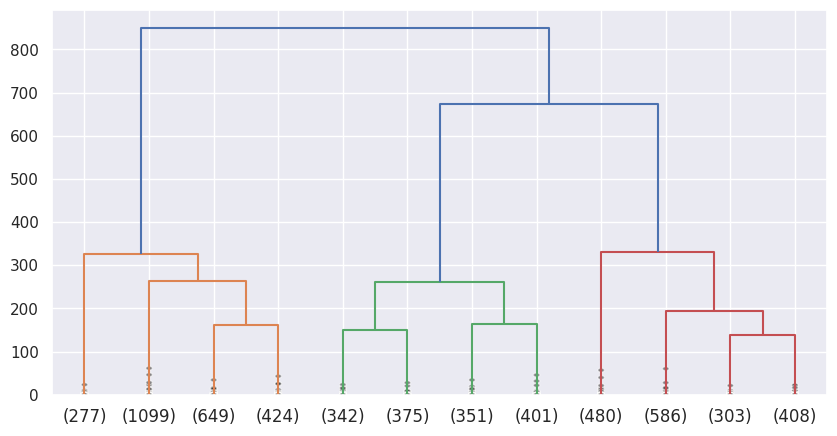

In [80]:
hc.dendrogram(hc_model_umap, truncate_mode='lastp', p=12, show_contracted=True)
plt.plot()

In [81]:
hc_list_umap = []
for k in clusters_umap:

    print('Iteration: {}'.format(k))

    # model definition and training
    hc_model_umap = hc.linkage(X_umap, 'ward')

    # model predict
    labels_umap = hc.fcluster(hc_model_umap, k, criterion='maxclust')

    # metrics
    sil_umap = metrics.silhouette_score(X_umap, labels_umap, metric='euclidean')
    hc_list_umap.append(sil_umap)

Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15


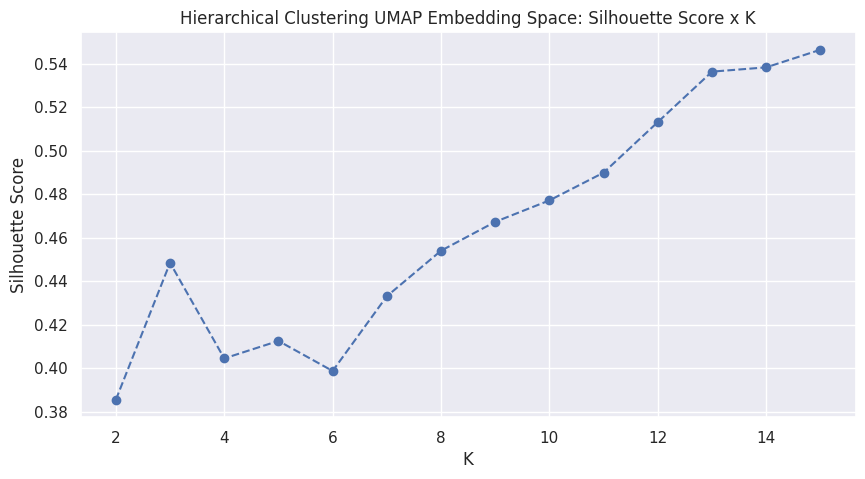

In [82]:
plt.plot(clusters_umap, hc_list_umap, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.title('Hierarchical Clustering UMAP Embedding Space: Silhouette Score x K');

### 8.3.3. t-SNE Embedding Space

In [83]:
# model definition and training
hc_model_tsne = hc.linkage(X_tsne, 'ward')

[]

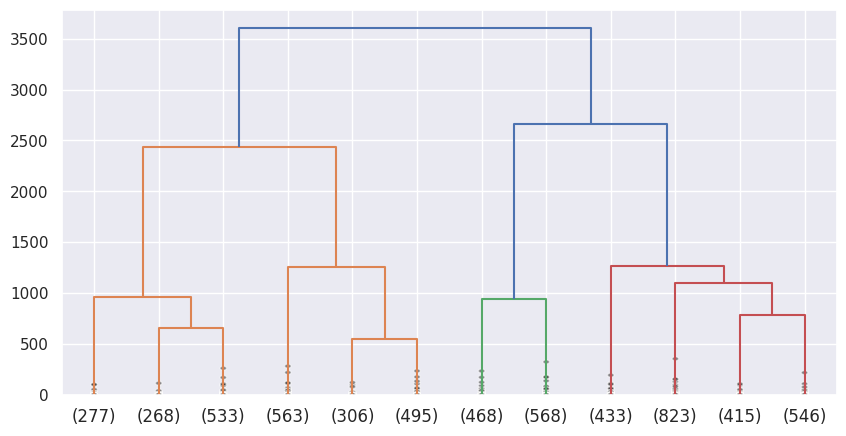

In [84]:
hc.dendrogram(hc_model_tsne, truncate_mode='lastp', p=12, show_contracted=True)
plt.plot()

In [85]:
hc_list_tsne = []
for k in clusters_tsne:

    print('Iteration: {}'.format(k))

    # model definition and training
    hc_model_tsne = hc.linkage(X_tsne, 'ward')

    # model predict
    labels_tsne = hc.fcluster(hc_model_tsne, k, criterion='maxclust')

    # metrics
    sil_tsne = metrics.silhouette_score(X_tsne, labels_tsne, metric='euclidean')
    hc_list_tsne.append(sil_tsne)

Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15


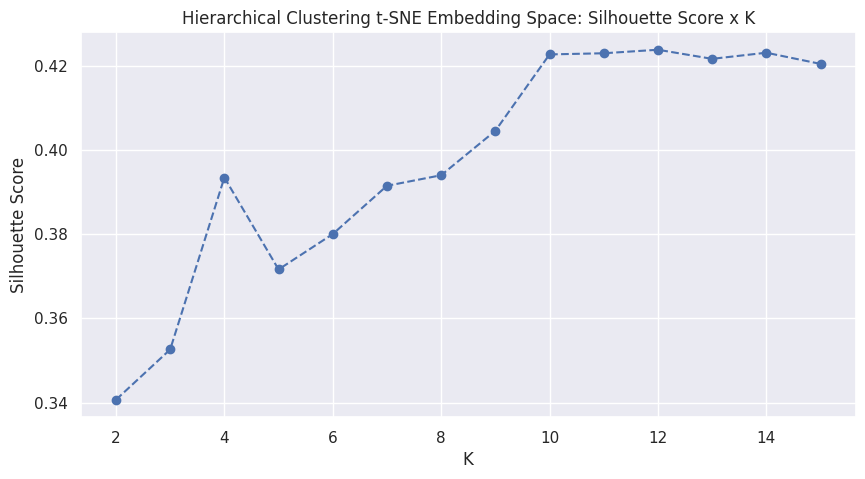

In [86]:
plt.plot(clusters_tsne, hc_list_tsne, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.title('Hierarchical Clustering t-SNE Embedding Space: Silhouette Score x K');

### 8.3.4. Tree Embedding Space

In [87]:
# model definition and training
hc_model_tree = hc.linkage(X_tree, 'ward')

[]

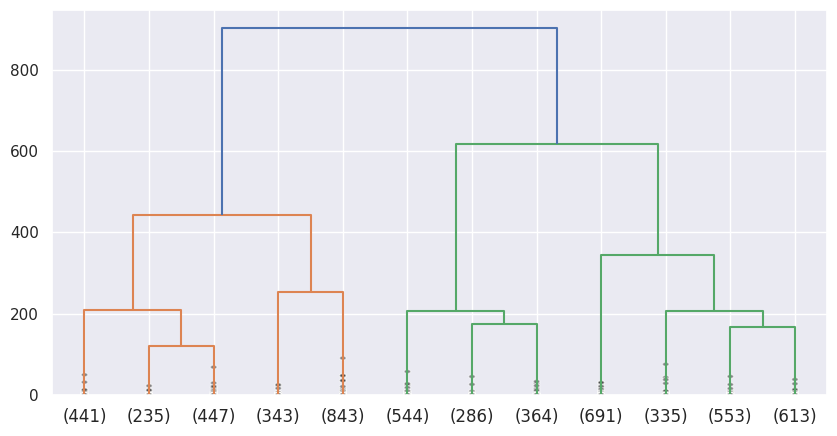

In [88]:
hc.dendrogram(hc_model_tree, truncate_mode='lastp', p=12, show_contracted=True)
plt.plot()

In [89]:
hc_list_tree = []
for k in clusters_tree:

    print('Iteration: {}'.format(k))

    # model definition and training
    hc_model_tree = hc.linkage(X_tree, 'ward')

    # model predict
    labels_tree = hc.fcluster(hc_model_tree, k, criterion='maxclust')

    # metrics
    sil_tree = metrics.silhouette_score(X_tree, labels_tree, metric='euclidean')
    hc_list_tree.append(sil_tree)

Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15


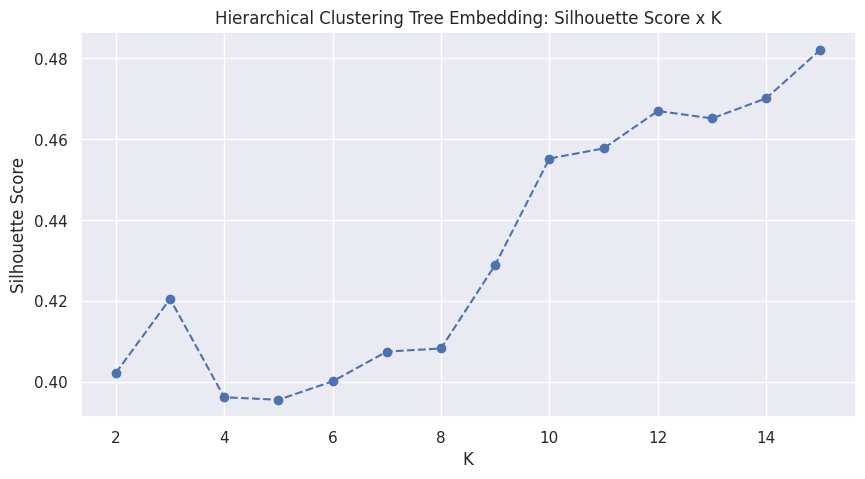

In [90]:
plt.plot(clusters_tree, hc_list_tree, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.title('Hierarchical Clustering Tree Embedding: Silhouette Score x K');

## 8.4. Results

### 8.4.1. Features Space

In [91]:
df_results = pd.DataFrame(
    {'KMeans': kmeans_list,
     'GMM': gmm_list,
     'HC': hc_list}).T

df_results.columns = clusters

In [92]:
df_results.style.highlight_max(color='darkgreen', axis=1)

### 8.4.2. UMAP Embedding Space

In [93]:
df_results_umap = pd.DataFrame(
    {'KMeans': kmeans_list_umap,
     'GMM': gmm_list_umap,
     'HC': hc_list_umap})

df_results_umap['n_clusters'] = clusters_umap

In [94]:
df_results_umap.style.highlight_max(color='darkgreen', axis=0)

### 8.4.3. t-SNE Embedding Space

In [95]:
df_results_tsne = pd.DataFrame(
    {'KMeans': kmeans_list_tsne,
     'GMM': gmm_list_tsne,
     'HC': hc_list_tsne})

df_results_tsne['n_clusters'] = clusters_tsne

In [96]:
df_results_tsne.style.highlight_max(color='darkgreen', axis=0)

### 8.4.4. Tree Embedding Space

In [97]:
df_results_tree = pd.DataFrame(
    {'KMeans': kmeans_list_tree,
     'GMM': gmm_list_tree,
     'HC': hc_list_tree})

df_results_tree['n_clusters'] = clusters_tree

In [98]:
df_results_tree.style.highlight_max(color='darkgreen', axis=0)

## 8.5. Silhouette Analysis

### 8.5.1. KMeans UMAP Embedding Space

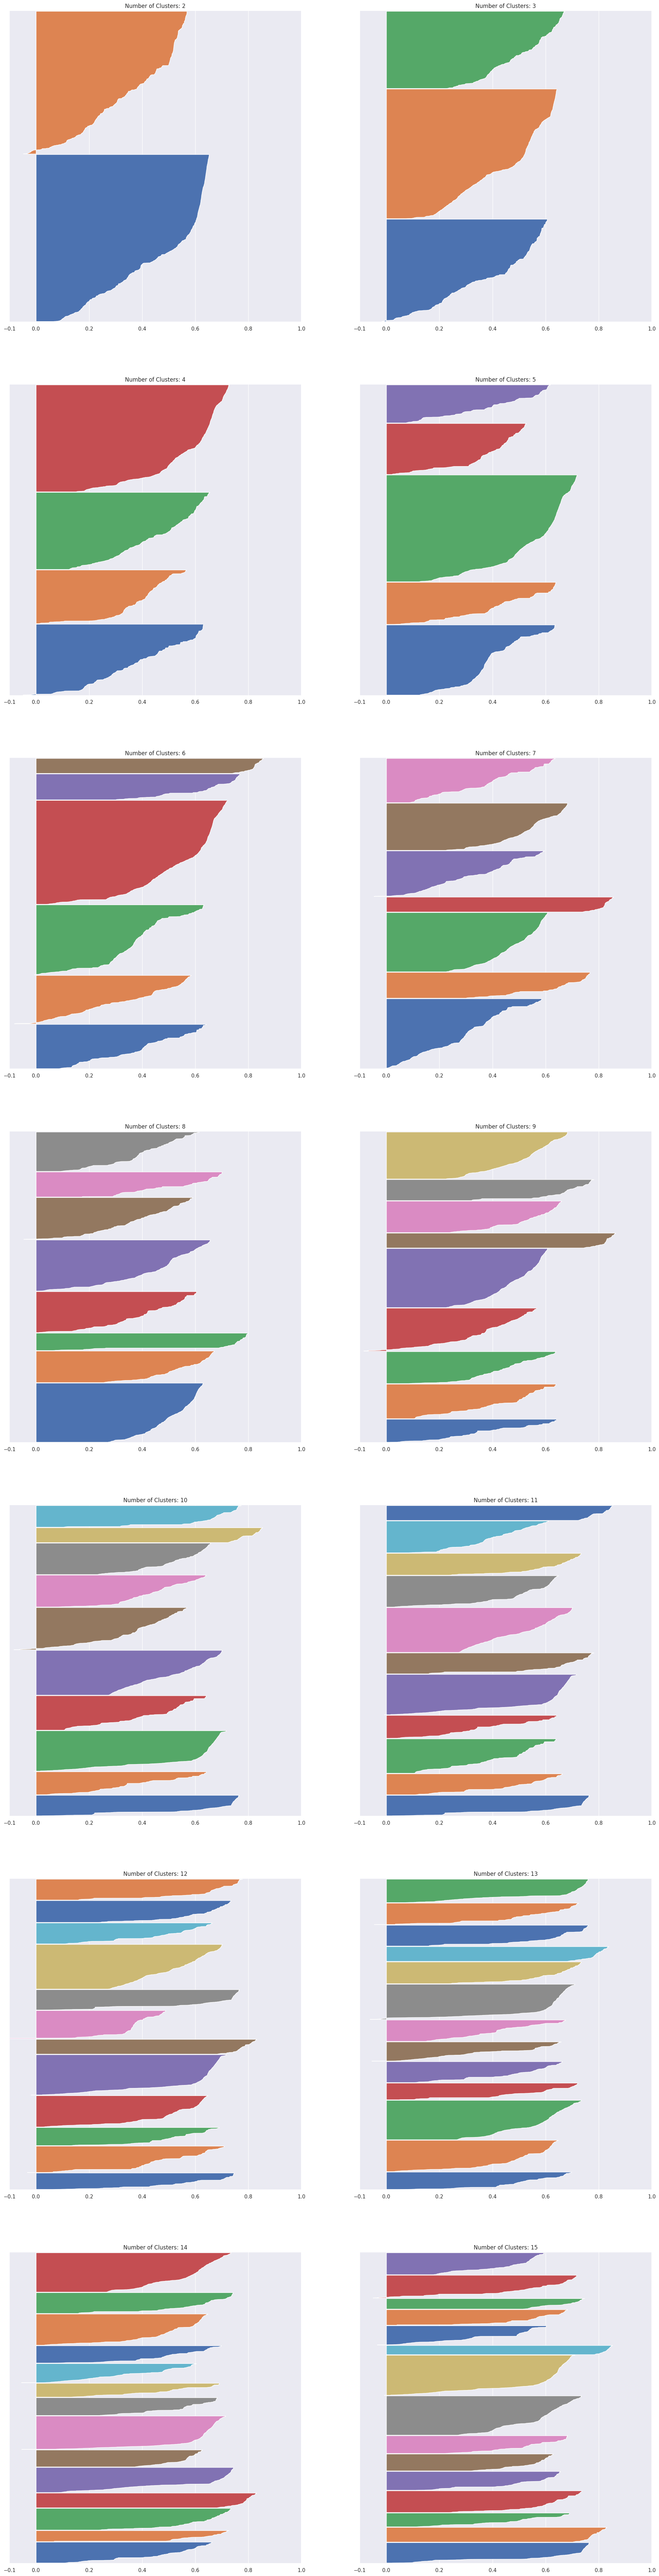

In [99]:
fig, ax = plt.subplots(7, 2)
fig.set_size_inches(25, 100)

for k in clusters_umap:
    q, mod = divmod(k, 2)
    
    ax[q-1, mod].set_xlim([ -0.1, 1])
    ax[q-1, mod].set_ylim([ 0, len(X_umap) + (k+1)*10])
    ax[q-1, mod].set_title('Number of Clusters: {}'.format(k))

    # model definition
    kmeans_model_umap = c.KMeans(init='random', n_clusters=k, n_init=500, max_iter=300, random_state=42)

    # model training
    kmeans_model_umap.fit(X_umap)

    # model predict
    labels_umap = kmeans_model_umap.predict(X_umap)

    # performance
    ss = metrics.silhouette_score(X_umap, labels_umap, metric='euclidean')
    #print('For K = {}. Silhouette Score: {}'.format(k, ss))

    samples_silhouette_values_umap = metrics.silhouette_samples(X_umap, labels_umap)

    y_lower = 10
    for i in range(k + 1):

        # select clusters
        ith_samples_silhouette_values_umap = samples_silhouette_values_umap[labels_umap == i]
        
        # sort values
        ith_samples_silhouette_values_umap.sort()

        # size clusters
        size_cluster_i_umap = ith_samples_silhouette_values_umap.shape[0]
        y_upper = y_lower + size_cluster_i_umap
        
        cmap = cm.get_cmap('Spectral')
        color = cmap(i / k)

        ax[q-1, mod].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_samples_silhouette_values_umap)
        
        y_lower = y_upper + 10
        
    ax[q-1, mod].set_yticks([])
    ax[q-1, mod].set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

### 8.5.2. KMeans Tree Embedding Space

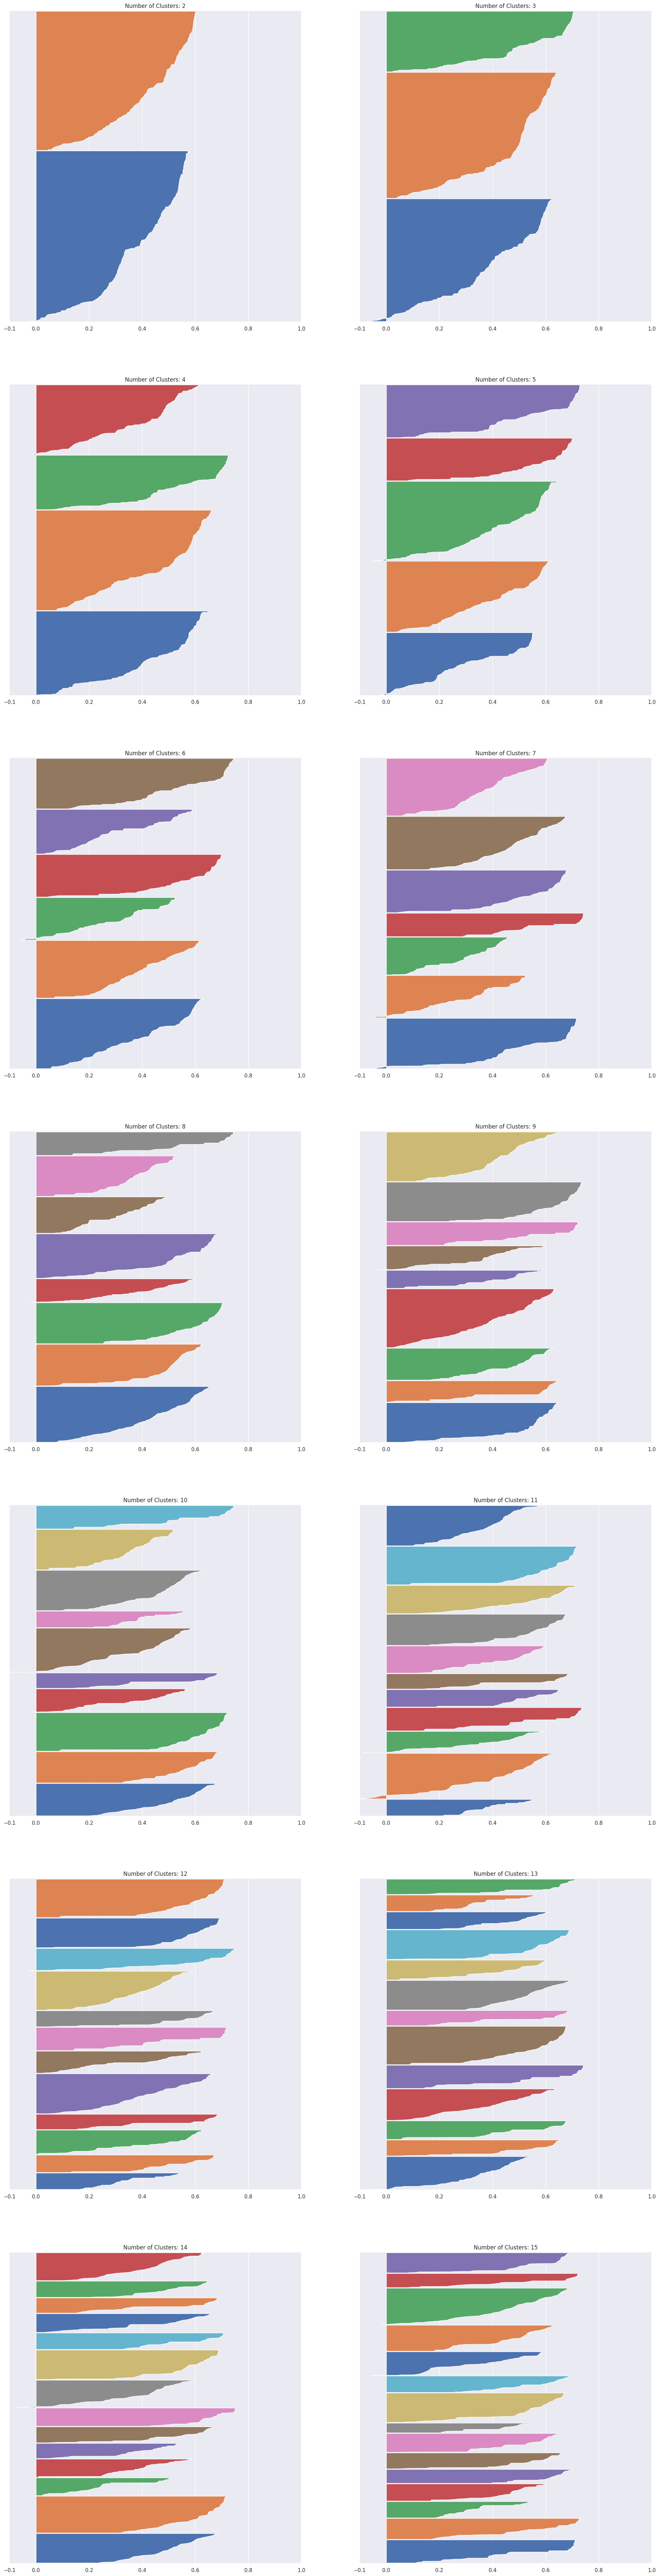

In [100]:
fig, ax = plt.subplots(7, 2)
fig.set_size_inches(25, 100)

for k in clusters_tree:
    q, mod = divmod(k, 2)
    
    ax[q-1, mod].set_xlim([ -0.1, 1])
    ax[q-1, mod].set_ylim([ 0, len(X_tree) + (k+1)*10])
    ax[q-1, mod].set_title('Number of Clusters: {}'.format(k))

    # model definition
    kmeans_model_tree = c.KMeans(init='random', n_clusters=k, n_init=500, max_iter=300, random_state=42)

    # model training
    kmeans_model_tree.fit(X_tree)

    # model predict
    labels_tree = kmeans_model_tree.predict(X_tree)

    # performance
    ss = metrics.silhouette_score(X_tree, labels_tree, metric='euclidean')
    #print('For K = {}. Silhouette Score: {}'.format(k, ss))

    samples_silhouette_values_tree = metrics.silhouette_samples(X_tree, labels_tree)

    y_lower = 10
    for i in range(k + 1):

        # select clusters
        ith_samples_silhouette_values_tree = samples_silhouette_values_tree[labels_tree == i]
        
        # sort values
        ith_samples_silhouette_values_tree.sort()

        # size clusters
        size_cluster_i_tree = ith_samples_silhouette_values_tree.shape[0]
        y_upper = y_lower + size_cluster_i_tree
        
        cmap = cm.get_cmap('Spectral')
        color = cmap(i / k)

        ax[q-1, mod].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_samples_silhouette_values_tree)
        
        y_lower = y_upper + 10
        
    ax[q-1, mod].set_yticks([])
    ax[q-1, mod].set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# 9. Model Training

## 9.1. K-Means UMAP Embedding Space

In [101]:
# model definition
k = 11
kmeans_umap = c.KMeans(init='random', n_clusters=k, n_init=500, max_iter=300, random_state=42)

# model training
kmeans_umap.fit(X_umap)

# clustering
labels_umap_kmeans = kmeans_umap.predict(X_umap)

In [102]:
# WSS
print('WSS Value: {}'.format(kmeans_umap.inertia_))

# SS
print('SS Value: {}'.format(metrics.silhouette_score(X_umap, labels_umap_kmeans, metric='euclidean')))

WSS Value: 53153.9375
SS Value: 0.5215659141540527


## 9.2. KMeans Tree Embedding Space

In [103]:
# model definition
k = 11
kmeans_tree = c.KMeans(init='random', n_clusters=k, n_init=500, max_iter=300, random_state=42)

# model training
kmeans_tree.fit(X_tree)

# clustering
labels_tree_kmeans = kmeans_tree.predict(X_tree)

In [104]:
# WSS
print('WSS Value: {}'.format(kmeans_tree.inertia_))

# SS
print('SS Value: {}'.format(metrics.silhouette_score(X_tree, labels_tree_kmeans, metric='euclidean')))

WSS Value: 72550.03125
SS Value: 0.46282827854156494


# 10. Cluster Analysis

## 10.1. KMeans UMAP Embedding Space

In [105]:
df9_umap_kmeans = X_umap
df9_umap_kmeans['cluster'] = labels_umap_kmeans

In [106]:
df9_umap_kmeans.head()

embedding_x  embedding_y  cluster
0      -7.1532       8.1363       10
1       7.6697      10.0700        6
2       3.4839      18.7296        0
3      13.6444       6.9062        1
4      -3.9575       1.5827        3

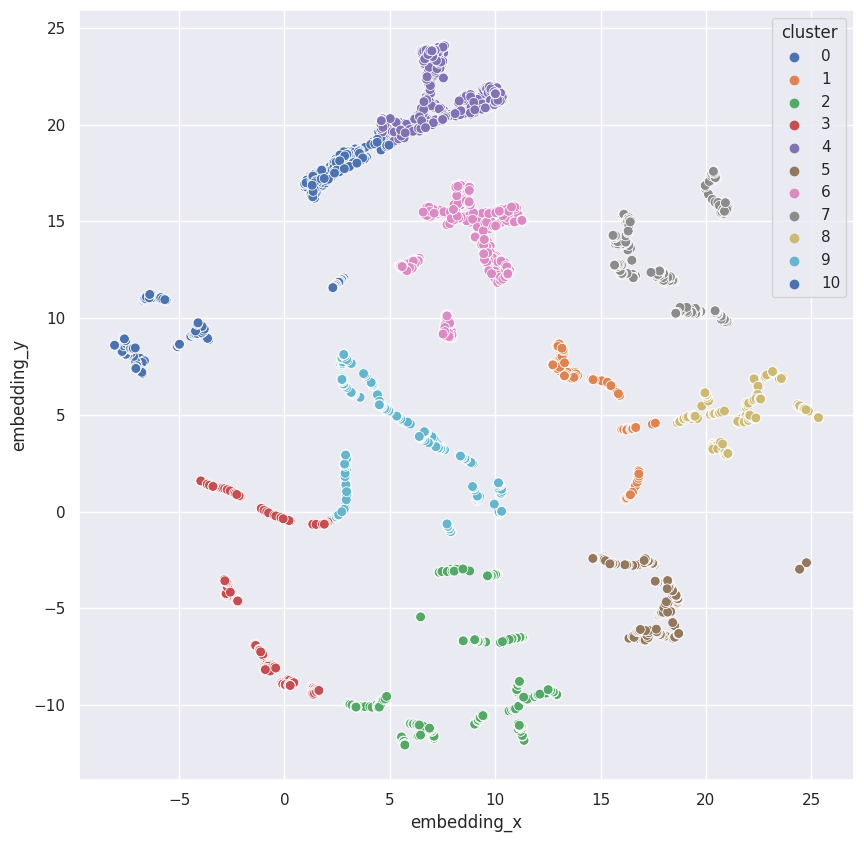

In [107]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x='embedding_x', y='embedding_y', hue='cluster', data=df9_umap_kmeans, s=50, palette='deep');

## 10.2. KMeans Tree Embedding Space

In [108]:
df9_tree_kmeans = X_tree
df9_tree_kmeans['cluster'] = labels_tree_kmeans

In [109]:
df9_tree_kmeans.head()

embedding_x  embedding_y  cluster
0       9.9231      -8.2271        9
1       6.9502      -6.5949        9
2       8.7015      -7.8303        9
3      21.5367      -0.2061        5
4      20.8157       9.0180        7

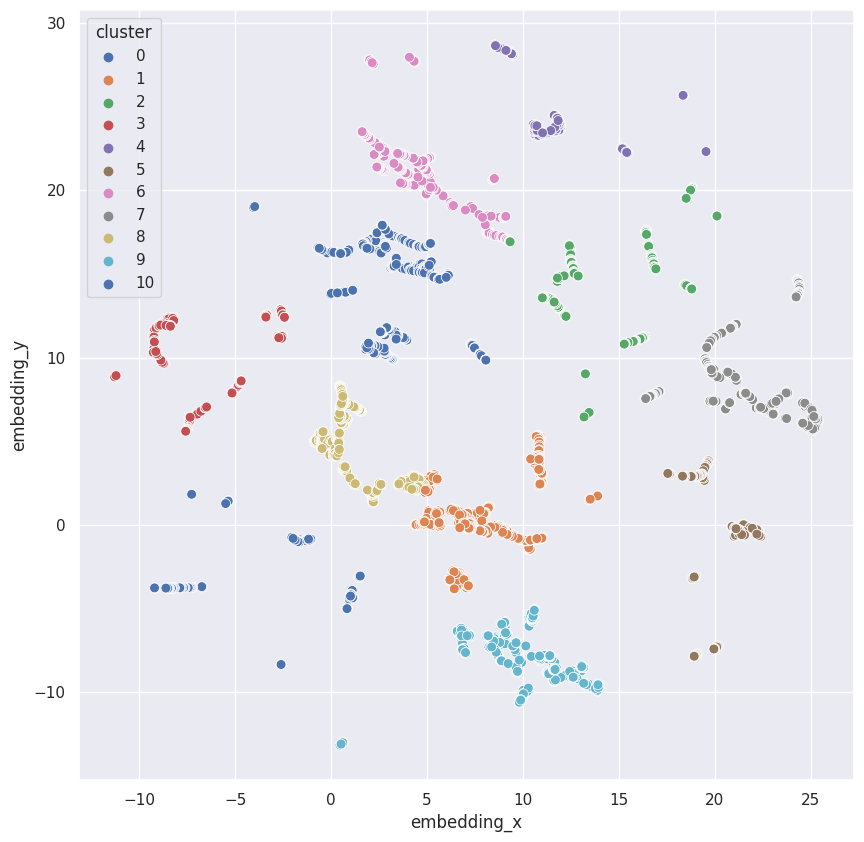

In [110]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x='embedding_x', y='embedding_y', hue='cluster', data=df9_tree_kmeans, s=50, palette='deep');

## 10.3. Clusters Profile

In [111]:
df9_2 = df4[cols_selected].copy()
df9_2['cluster'] = labels_umap_kmeans

# change data types
df9_2['cluster'] = df9_2['cluster'].astype('int64')
df9_2['recency_days'] = df9_2['recency_days'].astype('int64')
df9_2['q_products'] = df9_2['q_products'].astype('int64')
df9_2['q_returns'] = df9_2['q_returns'].astype('int64')

df9_2['last_training_timestamp'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

cluster_map = {4:0, 0:1, 6:2, 1:3, 3:4, 10:5, 7:6, 9:7, 5:8, 8:9, 2:10}
df9_2['cluster'] = df9_2['cluster'].map(cluster_map)

df9_2.head()

customer_id  gross_revenue  recency_days  q_products  frequency  q_returns  cluster last_training_timestamp
0        17850      5391.2100           372         297    17.0000         40        5     2022-11-26 17:39:31
1        13047      3232.5900            56         171     0.0283         35        2     2022-11-26 17:39:31
2        12583      6705.3800             2         232     0.0403         50        1     2022-11-26 17:39:31
3        13748       948.2500            95          28     0.0179          0        3     2022-11-26 17:39:31
4        15100       876.0000           333           3     0.0732         22        4     2022-11-26 17:39:31

In [112]:
# number of customers
df_cluster = df9_2[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = 100 * (df_cluster['customer_id'] / df_cluster['customer_id'].sum())

# average gross revenue
df_avg_gross_revenue = df9_2[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gross_revenue, how='inner', on='cluster')

# average recency days
df_avg_recency_days = df9_2[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency_days, how='inner', on='cluster')

# average invoice number
df_avg_invoice_no = df9_2[['q_products', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_invoice_no, how='inner', on='cluster')

# average frequency
df_avg_frequency = df9_2[['frequency', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_frequency, how='inner', on='cluster')

# average returns
df_avg_returns = df9_2[['q_returns', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_returns, how='inner', on='cluster')

In [113]:
df_cluster.sort_values('gross_revenue', ascending=False)

cluster  customer_id  perc_customer  gross_revenue  recency_days  q_products  frequency  q_returns
0         0          755        13.2572      6260.0893       11.6728    241.8848     0.0464    76.5828
1         1          383         6.7252      2663.6161        4.2298    175.4700     0.1400    17.4909
2         2          836        14.6795      1705.6163       36.6029     98.0682     0.0308    16.6890
3         3          392         6.8832      1164.3906      100.1658     61.7577     0.1876     8.3622
4         4          429         7.5329      1028.4589      290.7040     59.6760     0.6307   202.1981
5         5          277         4.8639       906.6248      362.5812     65.1264     1.0515     2.4729
6         6          586        10.2897       861.5481       35.1195     44.7270     0.7124     3.4522
7         7          595        10.4478       774.4285      135.1261     65.0571     0.7660     3.6924
8         8          391         6.8657       647.6219      199.1074     47.2302     1.0230     2.4476
9         9          408         7.1642       606.1519       56.2304     46.1422     1.0731     6.5956
10       10          643        11.2906       492.8762      246.7932     39.6112     1.0202     1.5988

# 11. EDA (Exploratory Data Analysis)

In [114]:
df10 = df9_2.copy()

## 11.1. Hypothesis Mindmap

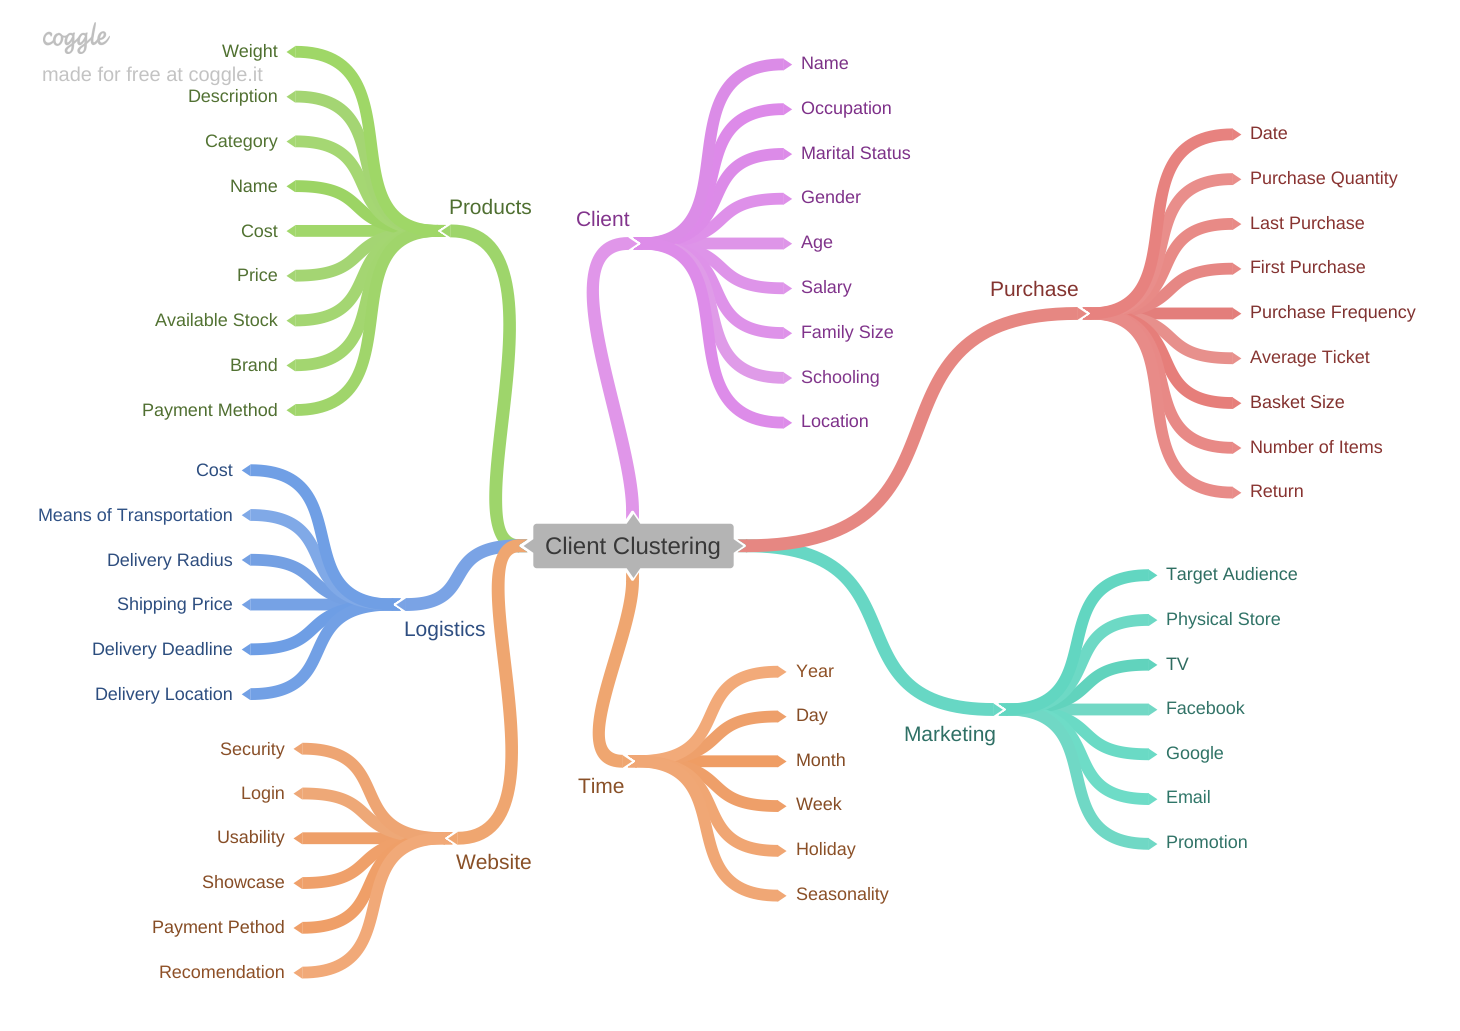

In [115]:
Image('../images/client_clustering.png')

## 11.2. Business Hypothesis

H1. The customers of the loyalty program have a purchase volume (products) above 10% of the total purchases.

True: The loyalty program cluster has 34% of the total products purchased.

In [116]:
df_sales_loyalty_program = df10.loc[df10['cluster'] == 0, 'q_products'].sum()
df_sales_total = df10.loc[:, 'q_products'].sum()

print('% Sales Insiders: {:.2f}%'.format(100*df_sales_loyalty_program / df_sales_total))

% Sales Insiders: 34.63%


H2. The customers of the loyalty program have a volume (revenue) of purchases above 10% of the total purchases.

True: The loyalty program cluster has 46% of the total profit.

In [117]:
df_gmv_loyalty_program = df10.loc[df10['cluster'] == 0, 'gross_revenue'].sum()
df_gmv_total = df10.loc[:, 'gross_revenue'].sum()

print('% GMV Insiders: {:.2f}%'.format(100*df_gmv_loyalty_program / df_gmv_total))

% GMV Insiders: 46.78%


H3. Loyalty program customers have a lower number of returns than the average of the other customers.

False: Loyalty program cluster has an average quantity of retuns above the average of the other customers

In [118]:
df_avg_return_loyalty_program = df10.loc[df10['cluster'] == 0, 'q_returns'].mean()

df_avg_return_all = df10['q_returns'].mean()

print('Avg Return Insiders: {} vs Avg Return All: {}'.format(np.round(df_avg_return_loyalty_program, 0), np.round(df_avg_return_all, 0)))

Avg Return Insiders: 77.0 vs Avg Return All: 31.0


H4. The median billing by loyalty program customers is 10% higher than the median billing overall.

True: The median of the profit from the loyalty program cluster is 215% above the overall median.

In [119]:
df_median_gmv_insiders = df10.loc[df10['cluster'] == 0, 'gross_revenue'].median()

df_median_gmv_total = df10.loc[:, 'gross_revenue'].median()

gmv_diff = (df_median_gmv_insiders - df_median_gmv_total) / df_median_gmv_total
print('Median Diff: {:.2f}%'.format(100 * gmv_diff))

Median Diff: 215.11%


H5. Loyalty program customers are on the third quantile.

False: They are mostly in the first quantile.

In [120]:
print(np.percentile(df10.loc[df10['cluster'] == 0, 'gross_revenue'], q=0.1))
print(np.percentile(df10.loc[df10['cluster'] == 0, 'gross_revenue'], q=0.9))

71.2008
174.83454


<AxesSubplot:xlabel='gross_revenue'>

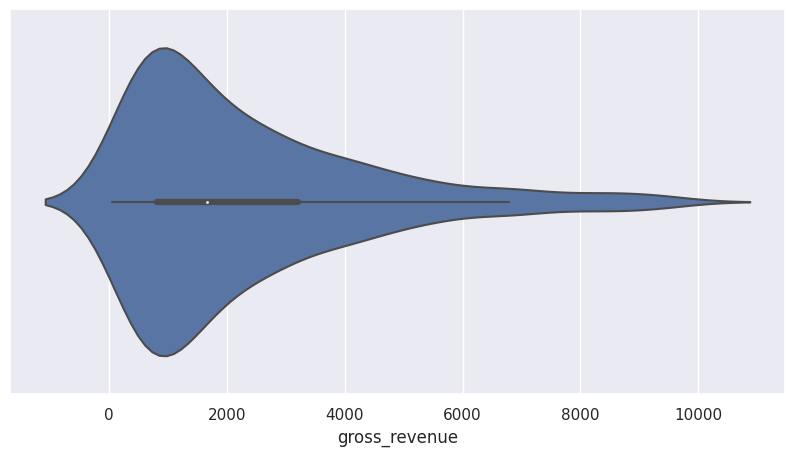

In [121]:
df_aux = df10.loc[(df10['cluster'] == 0) & (df10['gross_revenue'] < 10000), 'gross_revenue'];
sns.violinplot(x=df_aux)

<AxesSubplot:xlabel='gross_revenue'>

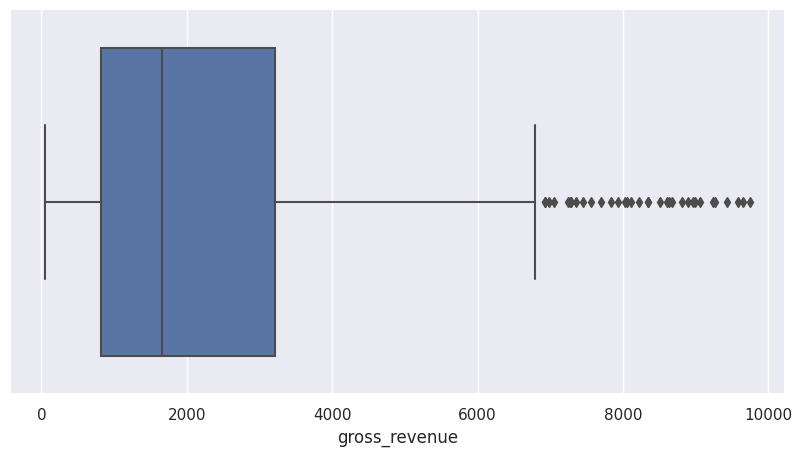

In [122]:
sns.boxplot(x=df_aux) 

## 11.3. Business Questions

1. Who are the elegible people to participate in the loyalty program?

In [123]:
df10.loc[df10['cluster'] == 0, 'customer_id'].head()

6     14688
7     17809
8     15311
12    16029
15    17511
Name: customer_id, dtype: int64

2. How many clients will be part of the loyalty program?

In [124]:
df10.loc[df10['cluster'] == 0, 'customer_id'].size

755

3. What are the main client characteristics?

In [125]:
df_cluster.query("cluster == 0")

cluster  customer_id  perc_customer  gross_revenue  recency_days  q_products  frequency  q_returns
0        0          755        13.2572      6260.0893       11.6728    241.8848     0.0464    76.5828

4. What is the percentage of profit contribution that comes from the loyalty program?

In [126]:
df_loyalty_program = df10.loc[df10['cluster'] == 0, 'gross_revenue'].sum()
df_all = df10.loc[:, 'gross_revenue'].sum()

print('% Gross Revenue from the Loyalty Program: {}%'.format(round(df_loyalty_program / df_all, 4) * 100))

% Gross Revenue from the Loyalty Program: 46.78%


# 12. Deployment

In [127]:
df9_2.dtypes

customer_id                  int64
gross_revenue              float64
recency_days                 int64
q_products                   int64
frequency                  float64
q_returns                    int64
cluster                      int64
last_training_timestamp     object
dtype: object

## 12.1. Insert Into SQLite

In [128]:
# database connection
conn = create_engine('sqlite:///../database/loyalty_program')

# drop table
query_drop_table_loyalty_program = """
    DROP TABLE loyalty_program
"""

# create table
query_create_table_loyalty_program = """
    CREATE TABLE loyalty_program(
        customer_id INTEGER,
        gross_revenue REAL,
        recency_days INTEGER,
        q_products INTEGER,
        frequency REAL,
        q_returns INTEGER,
        cluster INTEGER
    )
"""

conn.execute(query_drop_table_loyalty_program)

# insert data
df9_2.to_sql('loyalty_program', con=conn, if_exists='append', index=False)

5695

In [129]:
query_all_data = """
    SELECT * FROM loyalty_program lp
"""

df = pd.read_sql_query(query_all_data, conn)

df.head()

customer_id  gross_revenue  recency_days  q_products  frequency  q_returns  cluster last_training_timestamp
0        17850      5391.2100           372         297    17.0000         40        5     2022-11-26 17:39:31
1        13047      3232.5900            56         171     0.0283         35        2     2022-11-26 17:39:31
2        12583      6705.3800             2         232     0.0403         50        1     2022-11-26 17:39:31
3        13748       948.2500            95          28     0.0179          0        3     2022-11-26 17:39:31
4        15100       876.0000           333           3     0.0732         22        4     2022-11-26 17:39:31